In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../')
from src import AFDB_tools, treescore , foldseek2tree
import pandas as pd
import torch

In [2]:
from src import AFDB_tools
import os
import shutil
import random
import wget
import glob
from tqdm import tqdm


In [ ]:
scopdf = pd.read_csv('../SCOP_data/pdb_chain_scop_uniprot.csv')
print(scopdf)

       FA-DOMID FA-PDBID    FA-PDBREG FA-UNIID  FA-UNIREG  SF-DOMID SF-PDBID  \
0       8045703     3H8D  C:1143-1264   Q64331  1143-1264   8091604     3H8D   
1       8094330     6J56  A:1158-1282   Q9UM54  1167-1291   8094331     6J56   
2       8017835     3FKQ      A:1-116   D0VX10      1-116   8017836     3FKQ   
3       8021315     1XHF      A:2-122   P0A9Q1      2-122   8033695     1XHF   
4       8021787     1Y7P     B:79-215   O28869     79-215   8034167     1Y7P   
...         ...      ...          ...      ...        ...       ...      ...   
36895   8022870     1SCJ    B:307-377   P04189     36-106   8035250     1SCJ   
36896   8027500     1T1E     A:12-188   Q8RR56     12-188   8039879     1T1E   
36897   8027593     1JQG    A:4P-100P   O97389     18-109   8039972     1JQG   
36898   8028119     1KN6       A:4-76   P63239     31-103   8040498     1KN6   
36899   8028297     1KWM     A:1A-95A   P15086     16-110   8040676     1KWM   

         SF-PDBREG SF-UNIID  SF-UNIREG 

(array([485.,  72.,  31.,  13.,   7.,   2.,   6.,   1.,   2.,   1.]),
 array([ 11. ,  61.7, 112.4, 163.1, 213.8, 264.5, 315.2, 365.9, 416.6,
        467.3, 518. ]),
 <BarContainer object of 10 artists>)

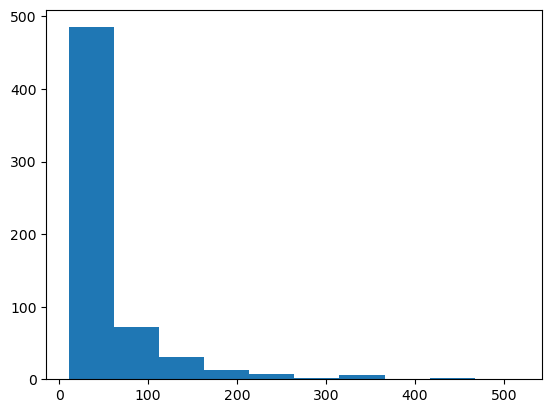

In [ ]:
scopdf = pd.read_csv('../SCOP_data/scop-cla-latest.txt', header = None, comment= '#' , sep = ' ')
scopdf.columns = 'FA-DOMID FA-PDBID FA-PDBREG FA-UNIID FA-UNIREG SF-DOMID SF-PDBID SF-PDBREG SF-UNIID SF-UNIREG SCOPCLA'.split()
scopdf['SF'] = scopdf['SCOPCLA'].map( lambda x : ''.join(x.split(',')[0-2]) )
print(scopdf)
vc = scopdf.SF.value_counts()
plt.hist( vc[vc>10])

done 64


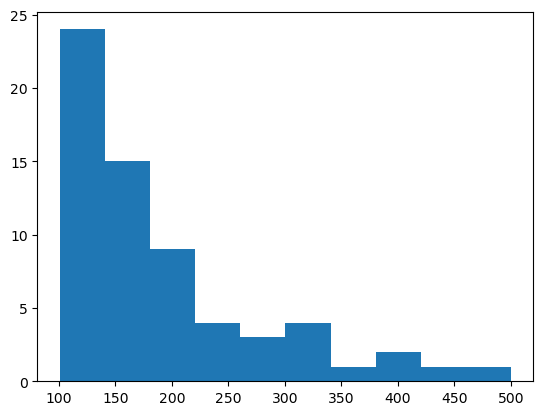

In [ ]:
from src import AFDB_tools
import os
datapath = '../SCOP_data/'
nprots = 500
fams = 2000
total = 0
lengths = []
#iterate over all superfamilies and create a tree for each
if not os.path.exists(datapath):
    os.mkdir(datapath)
for i,superfam in enumerate(scopdf.SF.unique()):
    if not os.path.exists(datapath+superfam):
        os.mkdir(datapath+superfam)
    #create a tree for each superfam
    #sample 1000 proteins from the superfam
    sub = scopdf[scopdf.SF == superfam]
    prots = list(sub['SF-UNIID'].unique())
    prots = prots[:nprots]
    #output the sequence dataset to a file
    #create a folder for the superfam if it does not exist
    #output the uniport ids to a file
    if len(prots)> 100:
        lengths.append(len(prots))
        total+=1
        with open(datapath+superfam+'/identifiers.txt', 'w') as f:
            f.write('\n'.join( prots ))
print('done', total)
plt.hist(lengths)
plt.show()


../../../datasets/Structure_Trees_mk2/Bacteria/


100%|██████████| 671/671 [00:08<00:00, 79.61it/s] 


../../../datasets/Structure_Trees_mk2/LUCA/


100%|██████████| 1392/1392 [00:03<00:00, 404.76it/s]


../../../datasets/Structure_Trees_mk2/Euteleostomi/


100%|██████████| 3267/3267 [00:02<00:00, 1569.24it/s]


../../../datasets/Structure_Trees_mk2/Eumetazoa/


100%|██████████| 1568/1568 [00:09<00:00, 159.26it/s]


../../../datasets/Structure_Trees_mk2/Chordata/


100%|██████████| 1038/1038 [00:05<00:00, 195.83it/s]


../../../datasets/Structure_Trees_mk2/Tetrapoda/


100%|██████████| 359/359 [00:00<00:00, 2109.65it/s]


../../../datasets/Structure_Trees_mk2/Opisthokonta/


100%|██████████| 662/662 [00:00<00:00, 840.90it/s]


../../../datasets/Structure_Trees_mk2/Dikarya/


100%|██████████| 186/186 [00:02<00:00, 82.18it/s] 


../../../datasets/Structure_Trees_mk2/Fungi/


100%|██████████| 138/138 [00:00<00:00, 797.28it/s]


../../../datasets/Structure_Trees_mk2/Bilateria/


100%|██████████| 1033/1033 [00:05<00:00, 198.95it/s]


../../../datasets/Structure_Trees_mk2/Eukaryota/


100%|██████████| 3218/3218 [00:41<00:00, 76.97it/s] 


{'../../../datasets/Structure_Trees_mk2/Bacteria/': 671, '../../../datasets/Structure_Trees_mk2/LUCA/': 1392, '../../../datasets/Structure_Trees_mk2/Euteleostomi/': 3267, '../../../datasets/Structure_Trees_mk2/Eumetazoa/': 1568, '../../../datasets/Structure_Trees_mk2/Chordata/': 1038, '../../../datasets/Structure_Trees_mk2/Tetrapoda/': 359, '../../../datasets/Structure_Trees_mk2/Opisthokonta/': 662, '../../../datasets/Structure_Trees_mk2/Dikarya/': 186, '../../../datasets/Structure_Trees_mk2/Fungi/': 138, '../../../datasets/Structure_Trees_mk2/Bilateria/': 1033, '../../../datasets/Structure_Trees_mk2/Eukaryota/': 3218}


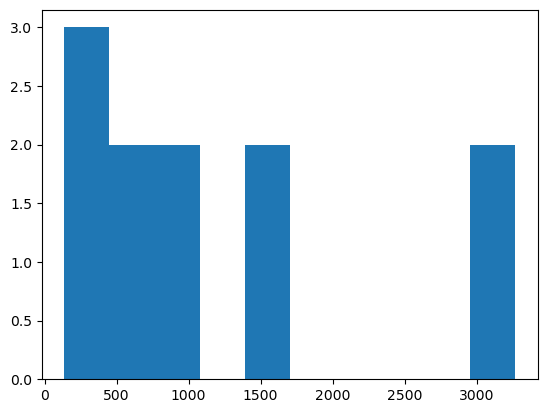

In [3]:
#subsample the oma folders

import os
import shutil
import random
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

#path to the oma folder
path = '../../../datasets/Structure_Trees_mk2/*/'
#path to the output folder
outpath = '../OMA_data/'

#make the output folder if it does not exist
if not os.path.exists(outpath):
    os.mkdir(outpath)
#number of proteins to sample
min_prots = 10
#number of superfamilies to sample
fams = 2000
superfams={}
#iterate over all superfamilies and compile an identifiers.txt file in the output folder
for clade in glob.glob(path):
    print(clade)
    if clade not in superfams:
        superfams[clade] = {}
    #stores length of each superfam
    superfam = set(glob.glob(clade+'*/'))-set([clade + 'logs/'])
    #use tqdm progress bar
    for s in tqdm(superfam):
        with open(clade+s+'identifiers.txt', 'r') as f:
                nprots = len(f.readlines())
        if nprots >= min_prots:
            superfams[clade][s] = nprots
lengths = { c:len(superfams[c]) for c in superfams}
print(lengths)
plt.hist(list(lengths.values()))
plt.show()


In [5]:
minlen = min(list(lengths.values()) )
print(minlen)
#clear output directory


#sample the superfamilies
for clade in superfams:
    cladestr = clade.split('/')[-2]+'/'
    if not os.path.isdir(outpath+cladestr):
        os.mkdir(outpath+cladestr)
    print(clade)    
    superfams[clade] = random.sample( list(superfams[clade]) ,  min( len(list(superfams[clade]))  , 500 )  )
    print(len(superfams[clade]))
    for s in tqdm(superfams[clade]):
        #copy the files to the output folder
        superfam = s.split('/')[-2]+'/'
        if not os.path.exists(outpath+cladestr+superfam):
            os.mkdir(outpath+cladestr+superfam)
            shutil.copy(s+'identifiers.txt', outpath+cladestr+superfam+'identifiers.txt')


138
../../../datasets/Structure_Trees_mk2/Bacteria/
500


100%|██████████| 500/500 [00:00<00:00, 256815.09it/s]


../../../datasets/Structure_Trees_mk2/LUCA/
500


100%|██████████| 500/500 [00:00<00:00, 257572.10it/s]


../../../datasets/Structure_Trees_mk2/Euteleostomi/
500


100%|██████████| 500/500 [00:00<00:00, 253738.90it/s]


../../../datasets/Structure_Trees_mk2/Eumetazoa/
500


100%|██████████| 500/500 [00:00<00:00, 254138.63it/s]


../../../datasets/Structure_Trees_mk2/Chordata/
500


100%|██████████| 500/500 [00:00<00:00, 267051.06it/s]


../../../datasets/Structure_Trees_mk2/Tetrapoda/
359


100%|██████████| 359/359 [00:00<00:00, 256386.03it/s]


../../../datasets/Structure_Trees_mk2/Opisthokonta/
500


100%|██████████| 500/500 [00:00<00:00, 255065.92it/s]


../../../datasets/Structure_Trees_mk2/Dikarya/
186


100%|██████████| 186/186 [00:00<00:00, 245095.99it/s]


../../../datasets/Structure_Trees_mk2/Fungi/
138


100%|██████████| 138/138 [00:00<00:00, 254088.65it/s]


../../../datasets/Structure_Trees_mk2/Bilateria/
500


100%|██████████| 500/500 [00:00<00:00, 260710.09it/s]


../../../datasets/Structure_Trees_mk2/Eukaryota/
500


100%|██████████| 500/500 [00:00<00:00, 269591.46it/s]
